In [ ]:
# Instalasi library yang dibutuhkan
!pip install -q diffusers transformers accelerate safetensors

In [ ]:
!pip freeze | grep -E "diffusers|transformers|accelerate|safetensors"

accelerate==1.12.0
diffusers==0.36.0
safetensors==0.7.0
sentence-transformers==5.2.0
transformers==4.57.3


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import modul-modul penting dari Diffusers
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    EulerAncestralDiscreteScheduler,
    DPMSolverMultistepScheduler,
    DDIMScheduler
)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"

# Memuat pipeline Text-to-Image
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    dtype=torch.float16, # Menggunakan presisi 16-bit agar hemat memori GPU
    use_safetensors=True,
    safety_checker=None
)

# Memindahkan proses ke GPU (CUDA)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

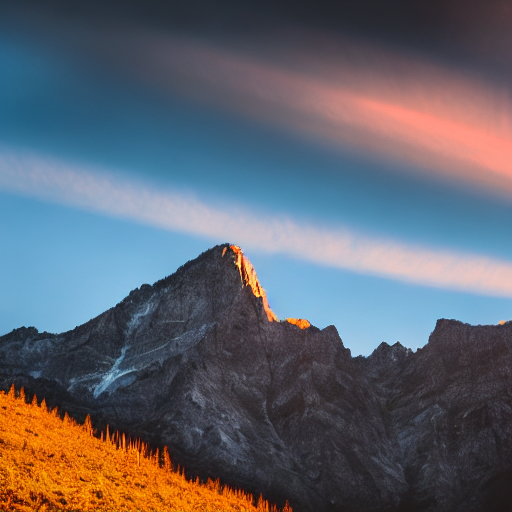

In [ ]:
# Prompt sederhana
prompt = "a cinematic photo of a mountain landscape at sunrise"

# Generate gambar
image_baseline = pipe(prompt).images[0]
image_baseline

  0%|          | 0/30 [00:00<?, ?it/s]

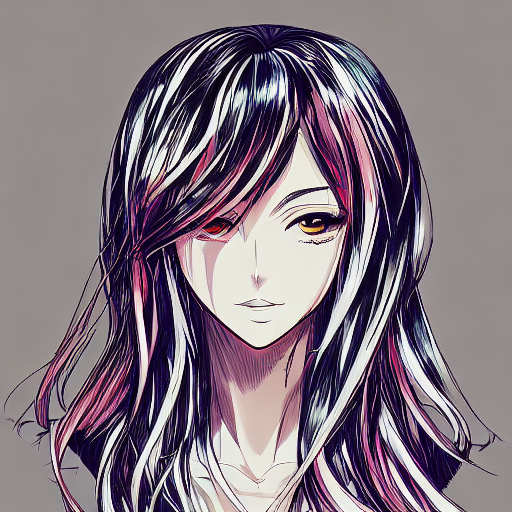

In [ ]:
prompt = "anime style illustration of a girl, clean lineart, vibrant colors, soft shading, studio quality, high detail, masterpiece"

# Kata kunci yang ingin kita hindari
negative_prompt = "realistic, photo, blurry, bad anatomy, extra fingers, mutated hands, watermark, text, low quality"

# Menggunakan Seed agar hasil konsisten
seed = 123
generator = torch.Generator("cuda").manual_seed(seed)

image_clean = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    num_inference_steps=30,
    generator=generator
).images[0]

image_clean

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

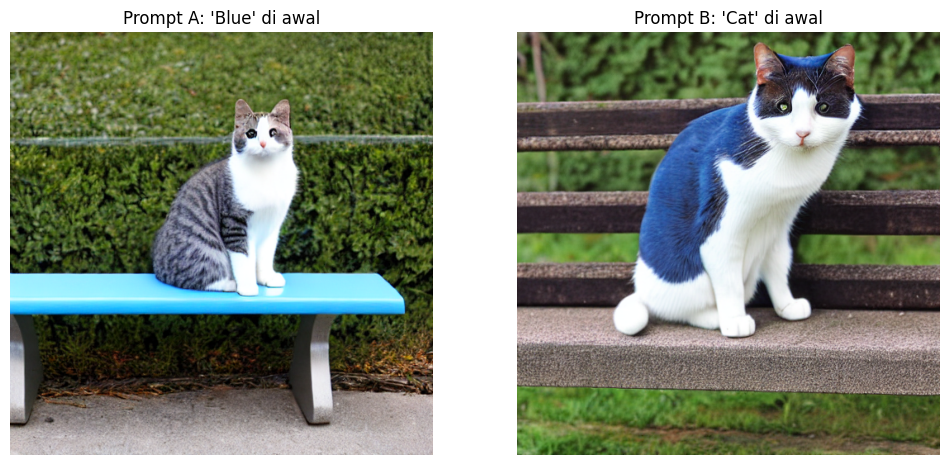

In [ ]:
# Skenario A: Warna 'Blue' di awal kalimat (Prioritas Warna)
prompt_A = "blue color, a cat sitting on a bench"

# Skenario B: Objek 'Cat' di awal kalimat (Prioritas Objek)
prompt_B = "a cat sitting on a bench, blue color"

generator = torch.Generator("cuda").manual_seed(42)

image_A = pipe(prompt_A, negative_prompt=negative_prompt, generator=generator).images[0]
image_B = pipe(prompt_B, negative_prompt=negative_prompt, generator=generator).images[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_A)
ax[0].set_title("Prompt A: 'Blue' di awal")
ax[0].axis("off")

ax[1].imshow(image_B)
ax[1].set_title("Prompt B: 'Cat' di awal")
ax[1].axis("off")
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

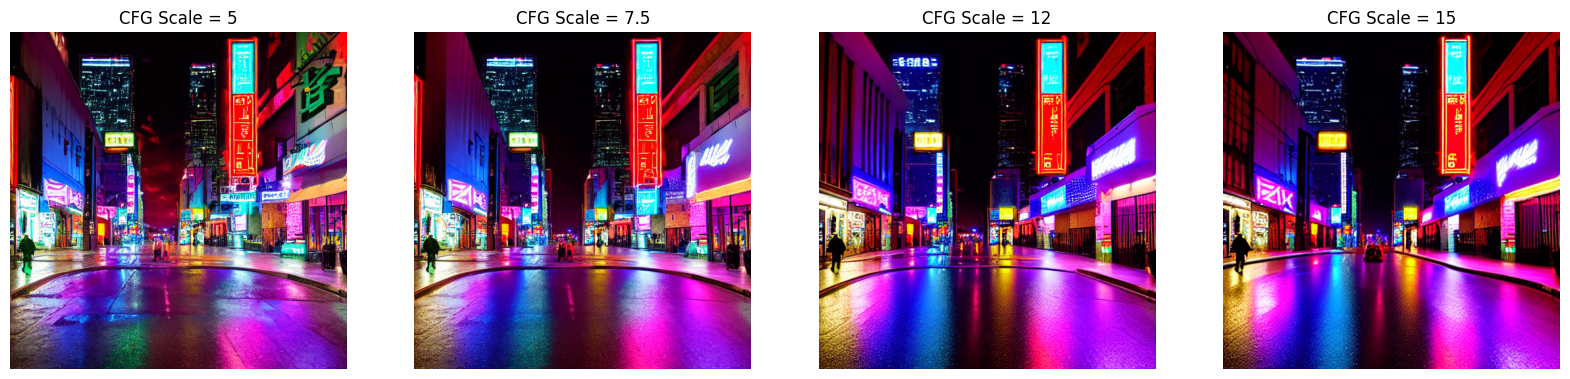

In [ ]:
guidance_scales = [5, 7.5, 12, 15]
images = []
prompt_cfg = "cyberpunk city street at night, neon lights, rain"

for scale in guidance_scales:
    generator = torch.Generator("cuda").manual_seed(123)
    img = pipe(
        prompt=prompt_cfg,
        negative_prompt=negative_prompt,
        guidance_scale=scale,
        generator=generator
    ).images[0]
    images.append(img)

plt.figure(figsize=(20, 5))
for i, img in enumerate(images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"CFG Scale = {guidance_scales[i]}")
    plt.axis("off")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

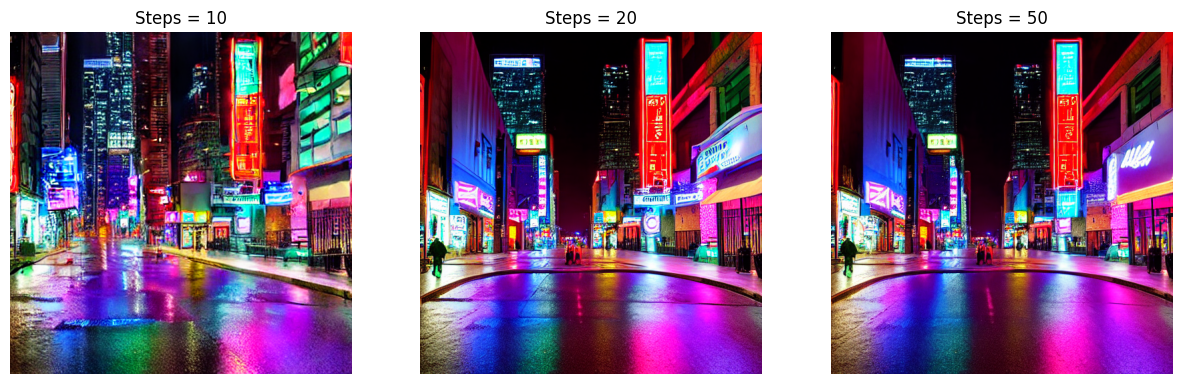

In [ ]:
steps_list = [10, 20, 50]
images = []

for steps in steps_list:
    generator = torch.Generator("cuda").manual_seed(123)
    img = pipe(
        prompt=prompt_cfg,
        negative_prompt=negative_prompt,
        num_inference_steps=steps,
        generator=generator
    ).images[0]
    images.append(img)

plt.figure(figsize=(15, 5))
for i, img in enumerate(images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Steps = {steps_list[i]}")
    plt.axis("off")
plt.show()

Generating dengan: Euler A...


  0%|          | 0/30 [00:00<?, ?it/s]

Generating dengan: DPM++ 2M Karras...


  0%|          | 0/30 [00:00<?, ?it/s]

Generating dengan: DDIM...


  0%|          | 0/30 [00:00<?, ?it/s]

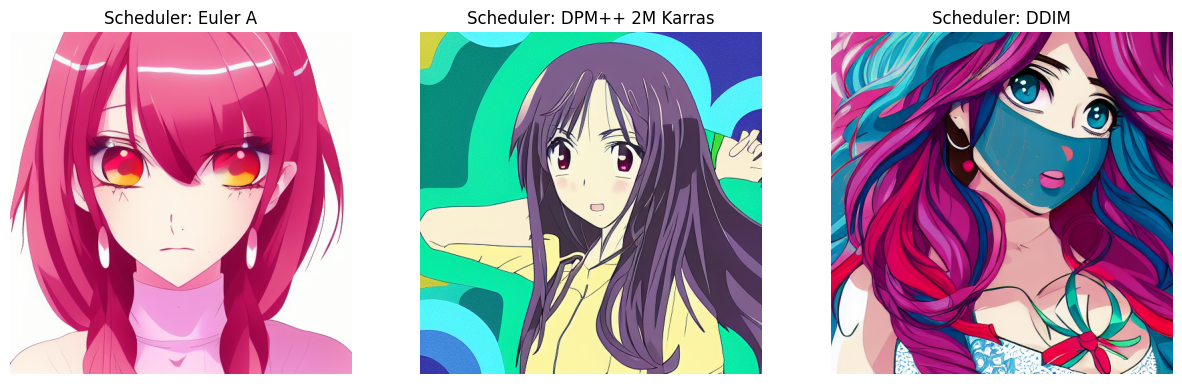

In [ ]:
# Scheduler yang akan diuji
scheduler_configs = [
    (EulerAncestralDiscreteScheduler, "Euler A"),
    (DPMSolverMultistepScheduler, "DPM++ 2M Karras"),
    (DDIMScheduler, "DDIM")
]

images = []
generator = torch.Generator("cuda").manual_seed(999)

for scheduler_class, name in scheduler_configs:
    # Mengganti scheduler pipeline
    pipe.scheduler = scheduler_class.from_config(pipe.scheduler.config)

    print(f"Generating dengan: {name}...")
    img = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        generator=generator,
        num_inference_steps=30
    ).images[0]
    images.append((name, img))

plt.figure(figsize=(15, 5))
for i, (name, img) in enumerate(images):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Scheduler: {name}")
    plt.axis("off")
plt.show()

  0%|          | 0/35 [00:00<?, ?it/s]

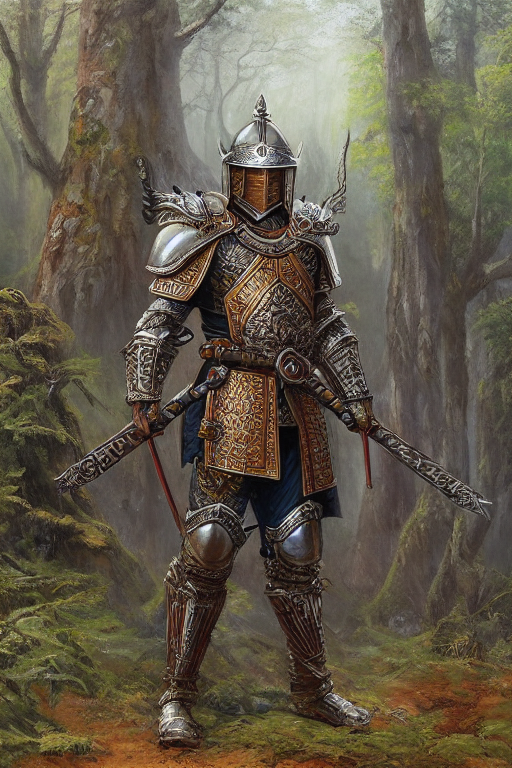

In [ ]:
prompt_portrait = "wide angle full body shot of a powerful male warrior in intricate full plate armor standing on forest ground, helmet on, visible feet to head, far view, fantasy forest background, masterpiece, highly detailed, epic fantasy artwork"
negative_prompt_portrait = negative_prompt + ", female, woman, girl, skirt, dress, cropped, cut off, out of frame, knee up shot, close up"

generator = torch.Generator("cuda").manual_seed(12345)

image_portrait = pipe(
    prompt=prompt_portrait,
    negative_prompt=negative_prompt_portrait,
    height=768, # Tinggi
    width=512,  # Lebar
    num_inference_steps=35,
    guidance_scale=8.5,
    generator=generator
).images[0]

image_portrait

  0%|          | 0/50 [00:00<?, ?it/s]

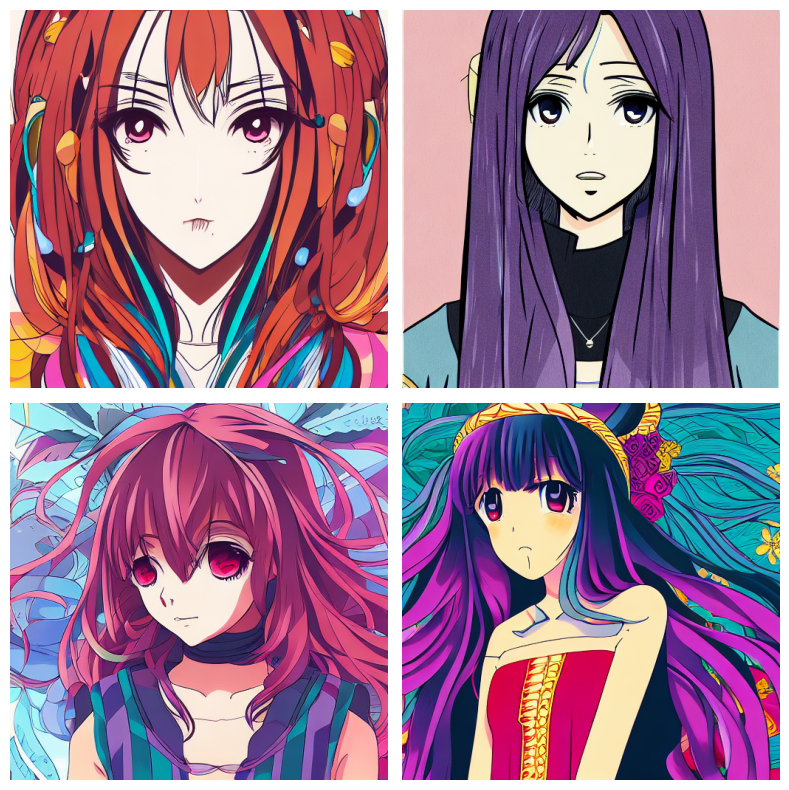

In [ ]:
generator = torch.Generator("cuda").manual_seed(42)

images_batch = pipe(
    prompt=[prompt] * 4,
    negative_prompt=[negative_prompt] * 4,
    generator=generator
).images

# Tampilkan Grid 2x2
plt.figure(figsize=(8, 8))
for i, img in enumerate(images_batch):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

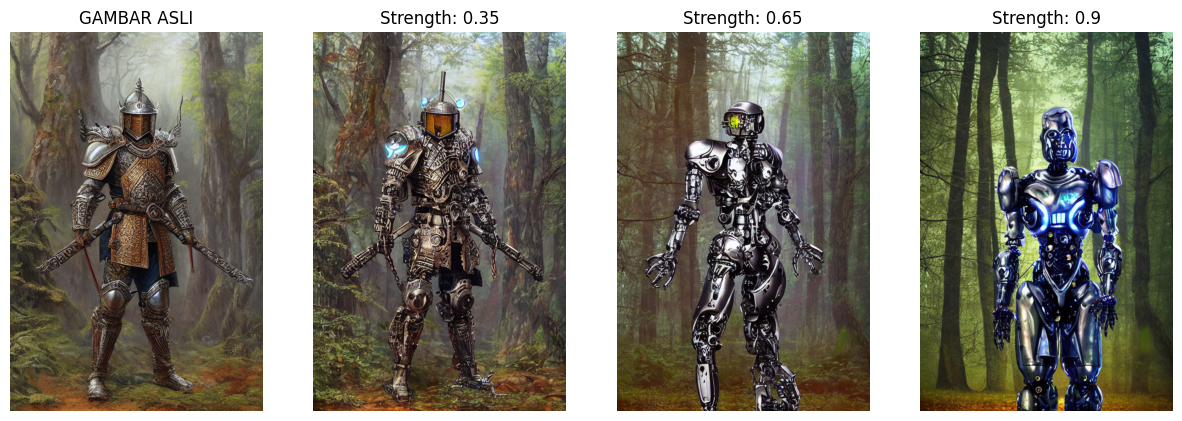

In [ ]:
# Pipeline baru khusus Img2Img
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_id,
    text_encoder=pipe.text_encoder,
    vae=pipe.vae,
    unet=pipe.unet,
    tokenizer=pipe.tokenizer,
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

init_image = image_portrait

# Prompt Baru
new_prompt = "full body shot of a cyborg robot, sci-fi metal armor, glowing eyes, fantasy forest background"

strengths = [0.35, 0.65, 0.9]
results = []

for val in strengths:
    generator = torch.Generator("cuda").manual_seed(100)
    res = img2img_pipe(
        prompt=new_prompt,
        image=init_image,
        strength=val,
        guidance_scale=8.0,
        generator=generator
    ).images[0]
    results.append(res)

plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(init_image)
plt.title("GAMBAR ASLI")
plt.axis("off")

for i, img in enumerate(results):
    plt.subplot(1, 4, i + 2)
    plt.imshow(img)
    plt.title(f"Strength: {strengths[i]}")
    plt.axis("off")

plt.show()

In [ ]:
torch.cuda.empty_cache()